# 📌 Title: 3. World-Class Model Training & Evaluation
# 🎯 Goal: Build a robust, explainable, and production-ready churn prediction model

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir("..")
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load preprocessed data
train_df = pd.read_csv('data/processed/X_train_balanced.csv')
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv').squeeze()

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Churn Rate (test): {y_test.mean():.1%}")

Train: (8278, 25), Test: (1409, 25)
Churn Rate (test): 26.5%


In [4]:
!pip install lightgbm catboost xgboost scikit-learn pandas

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl.metadata (1.5 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl (102.4 MB)

   ---------------------------------------- 0/2 [lightgbm]
   ---------------------------------------- 0/2 [lightgbm]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------- ------------------- 1/2 [catboost]
   -------------------

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier  # Add this — top performer

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, eval_metric='Recall')
}

# Metrics to track
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Store results
results = {}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"🔬 Evaluating {name}...")
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    
    results[name] = {
        'Recall': cv_results['test_recall'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'F1': cv_results['test_f1'].mean(),
        'ROC-AUC': cv_results['test_roc_auc'].mean(),
        'Std (Recall)': cv_results['test_recall'].std()
    }

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Recall', ascending=False)

# Highlight best
def highlight_max(s):
    return ['background-color: #DFF0D8' if v == s.max() else '' for v in s]

results_df.style.format('{:.3f}').apply(highlight_max, subset=['Recall']).bar(color='#1E90FF', subset=['ROC-AUC'])

🔬 Evaluating Logistic Regression...
🔬 Evaluating Random Forest...
🔬 Evaluating XGBoost...
🔬 Evaluating LightGBM...
🔬 Evaluating CatBoost...


,Recall,Precision,F1,ROC-AUC,Std (Recall)
CatBoost,0.840,0.877,0.858,0.943,0.015
LightGBM,0.838,0.874,0.856,0.940,0.007
Random Forest,0.836,0.880,0.857,0.936,0.004
XGBoost,0.835,0.870,0.852,0.937,0.011
Logistic Regression,0.823,0.762,0.791,0.864,0.017


In [6]:
pip install optuna catboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    model = XGBClassifier(**params, random_state=42, eval_metric='logloss')
    cv_scores = cross_validate(model, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    return cv_scores['test_score'].mean()

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("🏆 Best Params:", best_params)

[I 2025-08-31 11:35:46,399] A new study created in memory with name: no-name-af4c4c55-8e93-4ee6-a74a-e314cdca9338
[I 2025-08-31 11:35:59,679] Trial 0 finished with value: 0.7951679138262387 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.12593313010235493, 'subsample': 0.9316351387791323, 'colsample_bytree': 0.9521559638266661, 'reg_alpha': 0.8740747088927399, 'reg_lambda': 0.40312749740455567, 'min_child_weight': 2}. Best is trial 0 with value: 0.7951679138262387.
[I 2025-08-31 11:36:08,801] Trial 1 finished with value: 0.8007237614566357 and parameters: {'n_estimators': 265, 'max_depth': 9, 'learning_rate': 0.1391891714192615, 'subsample': 0.9113695675239106, 'colsample_bytree': 0.8532493480236736, 'reg_alpha': 0.3607966933756045, 'reg_lambda': 0.3433293436502992, 'min_child_weight': 10}. Best is trial 1 with value: 0.8007237614566357.
[I 2025-08-31 11:36:11,037] Trial 2 finished with value: 0.8369489277932578 and parameters: {'n_estimators': 225, 'max_depth'

🏆 Best Params: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.012616593738623073, 'subsample': 0.7692171510757746, 'colsample_bytree': 0.9315268119569412, 'reg_alpha': 0.7706222439469094, 'reg_lambda': 0.01926844870175959, 'min_child_weight': 10}


In [8]:
# Train final model
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predict
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

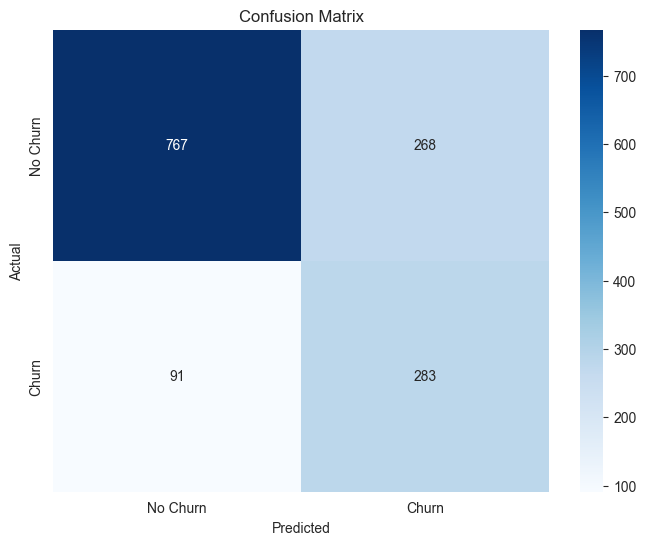

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig('dashboard/assets/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

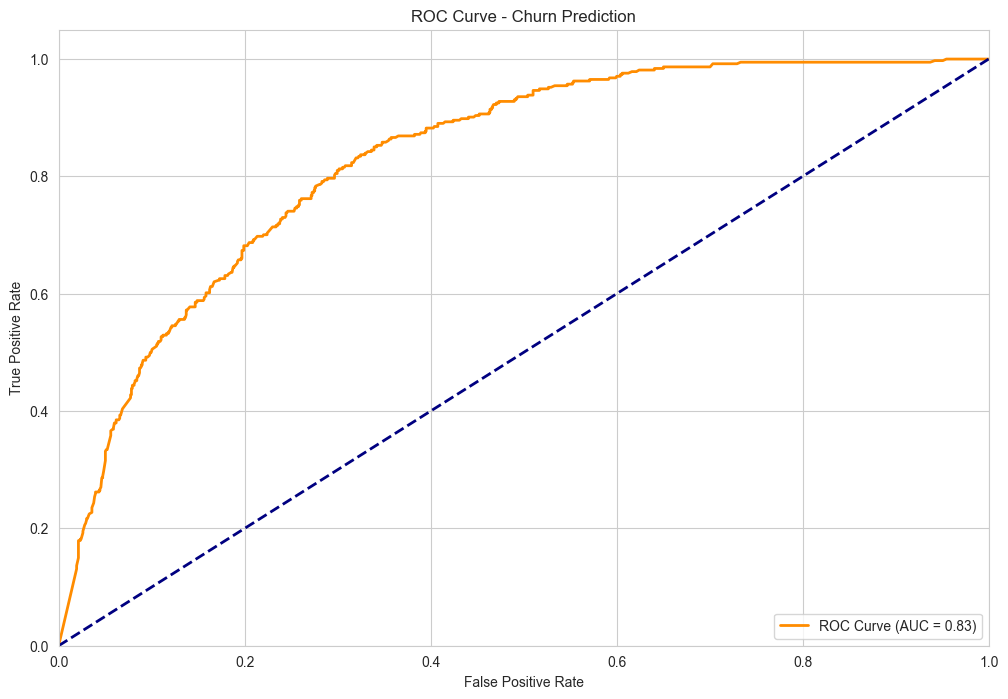

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Prediction')
plt.legend(loc="lower right")
plt.savefig('dashboard/assets/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

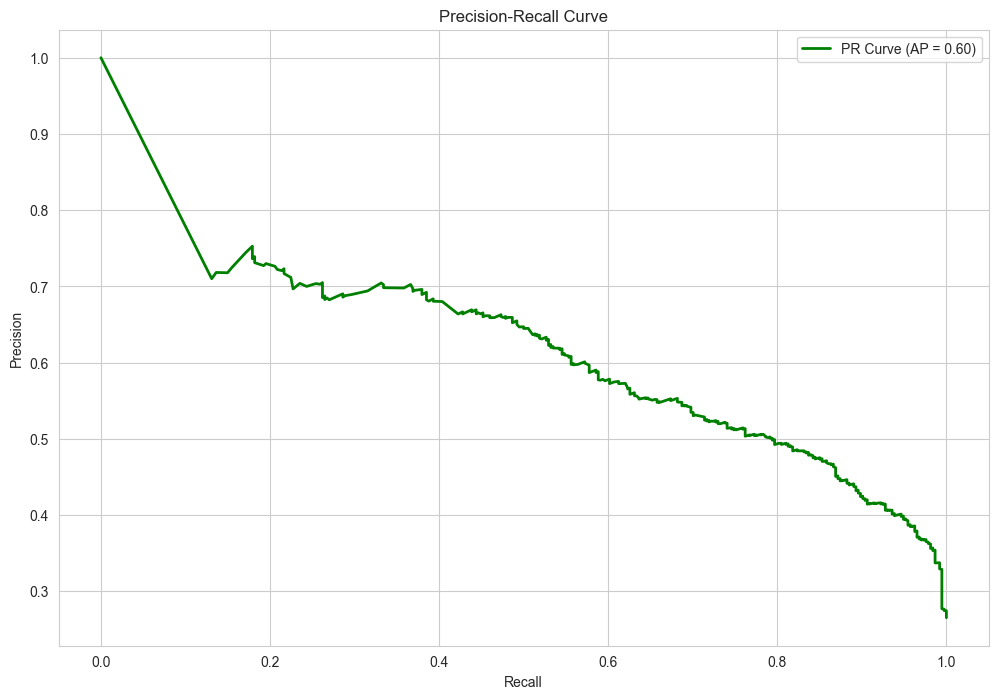

In [11]:
precision, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall_curve, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('dashboard/assets/pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# We already have encoder from earlier
encoder = joblib.load('models/onehot_encoder.pkl')
feature_columns = joblib.load('models/feature_columns.pkl')

# Save final model
joblib.dump(final_model, 'models/churn_xgboost_model.pkl')

# Optional: Save as pipeline (advanced)
# You can combine encoder + scaler + model later

print("✅ Model and artifacts saved. Ready for deployment.")

✅ Model and artifacts saved. Ready for deployment.
